# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Transcription-Factors-in-the-Hypoxic-Response" data-toc-modified-id="Transcription-Factors-in-the-Hypoxic-Response-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Transcription Factors in the Hypoxic Response</a></div><div class="lev1 toc-item"><a href="#Identify-the-transcription-factors-in-the-hypoxia-response" data-toc-modified-id="Identify-the-transcription-factors-in-the-hypoxia-response-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Identify the transcription factors in the hypoxia response</a></div><div class="lev2 toc-item"><a href="#A-slightly-less-restrictive-approach-reveals-even-more-Transcription-Factors" data-toc-modified-id="A-slightly-less-restrictive-approach-reveals-even-more-Transcription-Factors-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>A slightly less restrictive approach reveals even more Transcription Factors</a></div>

In this notebook, I dissect what transcription factors are present in the hypoxia response we defined earlier. 

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

import tissue_enrichment_analysis as tea
import morgan as morgan
import epistasis as epi
import genpy

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize
import gvars

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
tfs = pd.read_csv('../input/tf_list.csv')

In [3]:
q = 0.1
# this loads all the labels we need
genvar = gvars.genvars()

In [5]:
# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
sleuth_loc = '../sleuth/kallisto/'
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')
thomas.add_single_mutant(single_mutants)
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
thomas.set_qval()
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# load all the beta values for each genotype:
for file in os.listdir("../sleuth/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)
thomas.filter_data()

In [6]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.fancy_mapping[key]
    df['code'] = key
    frames += [df]
    df['sorter'] = genvar.sort_muts[key]

tidy = pd.concat(frames)
tidy.sort_values('sorter', inplace=True)
tidy.dropna(subset=['ens_gene'], inplace=True)

# Transcription Factors in the Hypoxic Response

First, it is useful to get an overview of the number of transcription factors involved. Therefore, I will explore how many TFs were present in each mutant transcriptome. 

In [7]:
codes = ['a', 'b', 'c', 'd', 'e', 'f']

print('Genotype, #TFs')
for c in codes:
    ind = (tidy.qval < q) & (tidy.code == c) & (tidy.target_id.isin(tfs.target_id))
    print(genvar.mapping[c], tidy[ind].shape[0])

Genotype, #TFs
egl-9;vhl-1 56
egl-9 31
hif-1 24
vhl-1 16
rhy-1 41
egl-9;hif-1 14


Next, I will extract the hypoxia response from this dataset. Remember, the hypoxia response is equivalent to the intersection of the *egl-9*, *rhy-1*, and *vhl-1* containing mutants. 

In [8]:
# extract the hypoxia response:
hyp_response_pos = epi.find_overlap(['e', 'b', 'a', 'd'], tidy[tidy.b > 0])
hyp_response_neg = epi.find_overlap(['e', 'b', 'a', 'd'], tidy[tidy.b < 0])
hyp_response = list(set(hyp_response_neg + hyp_response_pos))

# Identify the transcription factors in the hypoxia response

Let's extract them, and plot them.

In [9]:
# find tfs in the hif-1 response
tfs_in_hif = tfs[tfs.target_id.isin(hyp_response)].target_id
print('There are {0} transcription factors in HIF-1+ animals'.format(tfs_in_hif.shape[0]))

# The qPCR function I wrote is quite stupid, so I always have to tidy up my dataframe a little
# bit and add a couple of columns:

# select the data to be plotted:
plotdf = tidy[tidy.target_id.isin(tfs_in_hif)].copy()
# sort by genotype
plotdf.sort_values(['genotype', 'target_id'], inplace=True)
# add an 'order' column
plot_order = {i: t+1 for t, i in enumerate(plotdf.target_id.unique())}
plotdf['order'] = plotdf.target_id.map(plot_order)
# sort by 'order'
plotdf.sort_values('order', inplace=True)
plotdf.reset_index(inplace=True)  

There are 7 transcription factors in HIF-1+ animals


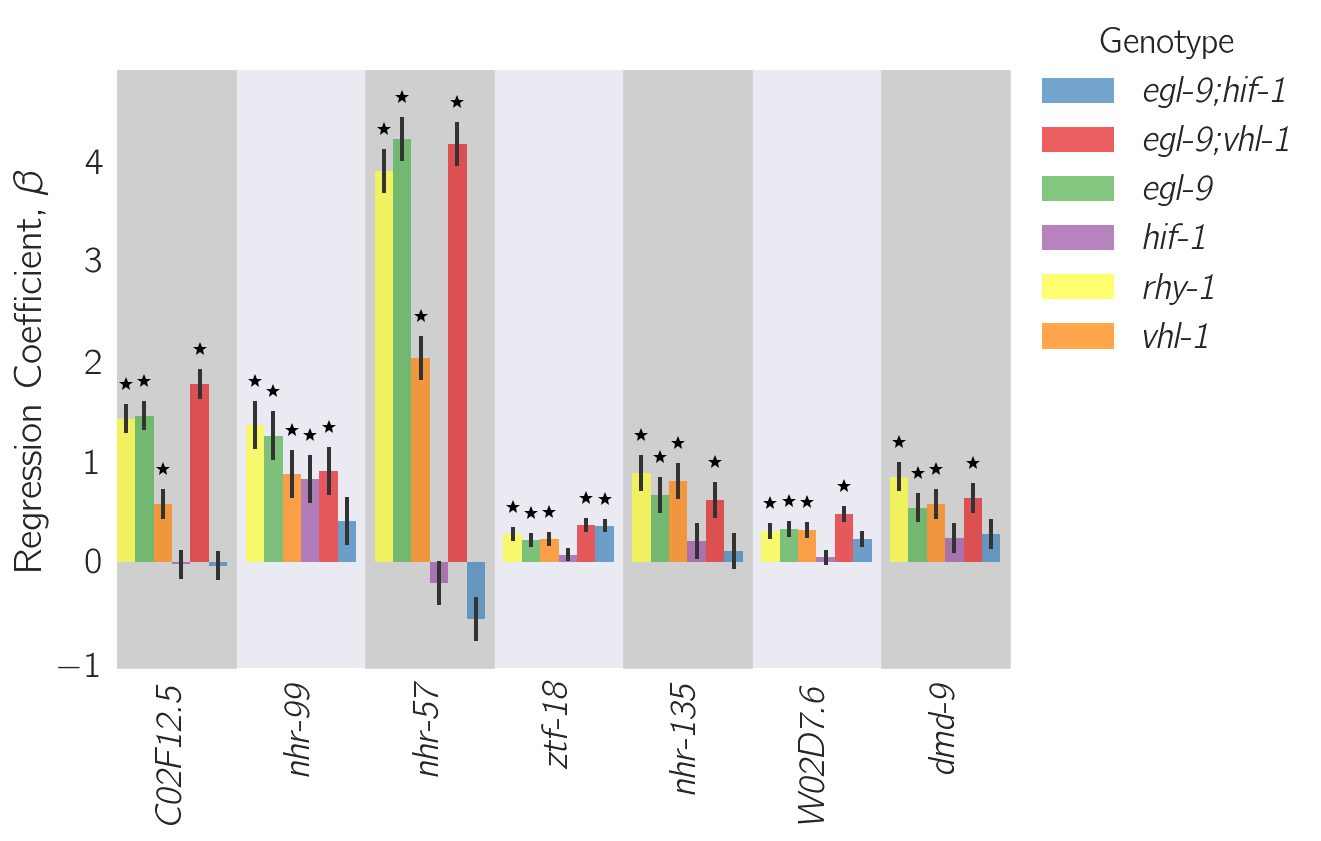

In [10]:
genpy.qPCR_plot(plotdf[plotdf.code != 'g'], genvar.plot_order, genvar.plot_color, clustering='genotype',
                plotting_group='target_id', rotation=90)

## A slightly less restrictive approach reveals even more Transcription Factors

*vhl-1* has the weakest transcriptomic phenotype and as a result strongly constrains what we call a hypoxia response. What TFs come out if we just find the intersection between *egl-9*, *rhy-1* and *egl-9;vhl-1* genotypes?

In [11]:
# extract the hypoxia response:
hyp_response_pos = epi.find_overlap(['e', 'b', 'a'], tidy[tidy.b > 0])
hyp_response_neg = epi.find_overlap(['e', 'b', 'a'], tidy[tidy.b < 0])
hyp_response = list(set(hyp_response_neg + hyp_response_pos))

In [12]:
print('There are {0} isoforms in the relaxed hypoxia response'.format(len(hyp_response)))
tfs_in_hif = tfs[tfs.target_id.isin(hyp_response)].target_id
print('There are {0} transcription factors in HIF-1+/HIF-1OH- animals'.format(tfs_in_hif.shape[0]))

plotdf = tidy[tidy.target_id.isin(tfs_in_hif)].copy()
plotdf.sort_values(['genotype', 'target_id'], inplace=True)
plot_order = {i: t+1 for t, i in enumerate(plotdf.target_id.unique())}
plotdf['order'] = plotdf.target_id.map(plot_order)
plotdf.sort_values('order', inplace=True)
plotdf.reset_index(inplace=True)  
plotdf = plotdf[['target_id', 'ens_gene', 'ext_gene','b', 'se_b', 'qval', 'genotype', 'order', 'code']]

There are 1477 isoforms in the relaxed hypoxia response
There are 15 transcription factors in HIF-1+/HIF-1OH- animals


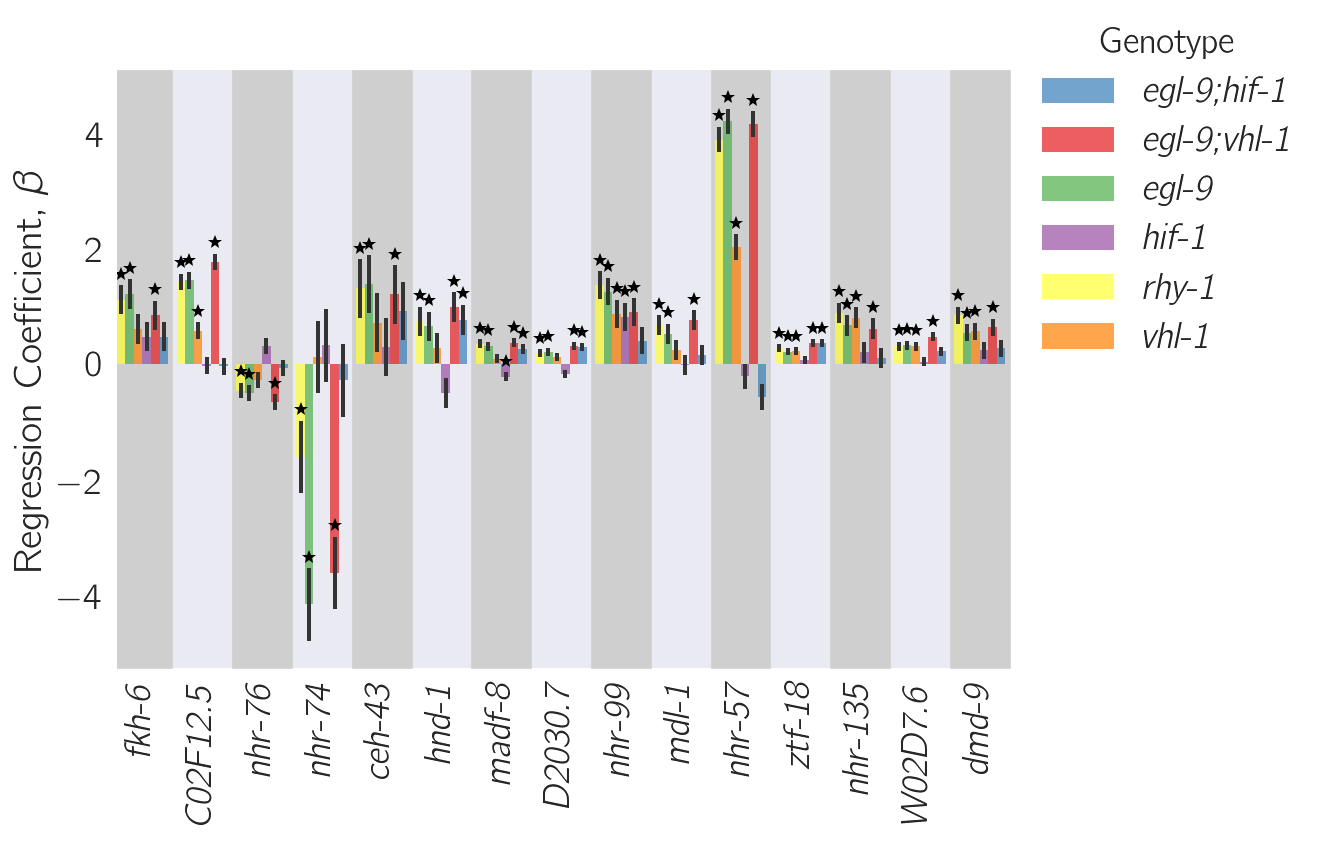

In [13]:
genpy.qPCR_plot(plotdf[plotdf.code != 'g'], genvar.plot_order, genvar.plot_color, clustering='genotype',
                plotting_group='target_id', rotation=90)